# Category Recommendation System Using RNN
**Author: Hafiz Fahrurrozi**

Text classification is crucial along with growing size of articles on the web. Sometimes the would-be-reader are having difficulties finding relevant article by category. To help writers and readers alike, we create a simple category recommendation model using Recurrent Neural Network.

The dataset used is taken from kaggle:
 - MIND: Microsoft News Recommendation Dataset ([kaggle](https://www.kaggle.com/arashnic/mind-news-dataset))
 - News Categorization Dataset ([kaggle](https://www.kaggle.com/rmisra/news-category-dataset))
 - BBC News Archive ([kaggle](https://www.kaggle.com/hgultekin/bbcnewsarchive))
 - BBC articles fulltext and category ([kaggle](https://www.kaggle.com/yufengdev/bbc-fulltext-and-category))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, re, gensim
from yake import KeywordExtractor
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics, model_selection, preprocessing

In [2]:
%load_ext Cython

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
nltk.download('stopwords')

stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
raw = pd.read_csv('news_category_dataset_v2.csv')
raw.head()

,category,headline,short_description,text
0,crime,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,"DENTON, Texas â€• Amanda Painter sat at the ki..."
1,entertainment,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,The 2018 FIFA World Cup starts June 14 in Russ...
2,entertainment,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,Love actually turned to matrimony for Hugh Gra...
3,entertainment,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...,Rep. Adam Schiff (D-Calif.) and fellow Democra...
4,entertainment,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ...",Actress Julianna Margulies unleashed her funny...


In [6]:
raw.category.value_counts()

lifestyle        20052
politics         19150
entertainment    18803
wellness         17828
fashion          15393
other            14966
sport            13123
economy          12347
opinion          11972
travel            9927
world news        8419
culinary          8345
tech              4801
environment       4092
crime             3618
religion          2556
science           2215
education         2200
Name: category, dtype: int64

In [7]:
raw = raw.fillna(' ')
raw['content'] = raw.headline + '. ' + raw.short_description + ' ' + raw.text
cln = raw[['category','content']]

In [8]:
# separate features from target
x = cln.content.str.lower()
y = cln.category.str.lower()

# encode target categories
enc = preprocessing.LabelBinarizer()
yt = enc.fit_transform(y)

In [9]:
%%time
# set input vector and output vector for word-to-vector models and LSTM model
invec = 10
outvec = 150
cat = len(y.unique())

# extract keywords from documents
kwe1 = KeywordExtractor(n=1, top=invec, stopwords=stop_words)
z = []
for j in range(len(x)):
    keywords = kwe1.extract_keywords(text=x[j])
    z.append([x for x,y in keywords])

# learn word vectors
w2v_model = gensim.models.Word2Vec(sentences=z, vector_size=outvec, min_count=2, workers=4)
w2v_model.save('mod1.wordvectors')

# keep keyvector, delete model
wv = w2v_model.wv
del(w2v_model)

# number of words library
print('Number of words :',len(wv))

# tokenize keywords to numbers
tkn = keras.preprocessing.text.Tokenizer()
tkn.fit_on_texts(z)
xt = tkn.texts_to_sequences(z)

# print examples
win = tkn.word_index
for word, num in win.items():
    print(f"{word} -> {num}")
    if num == 5:
        break

# set number of units in word-to-vector layer
vocab_size = len(win) + 1

# function to get weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, outvec))
    for word, i in vocab.items():
        if word not in model:
            weight_matrix[i] = 0
        else:
            weight_matrix[i] = model[word]
    return weight_matrix

# store the weights inside a variable
emvec = get_weight_matrix(wv, win)

# pad sentences shorter than input vector
# also trims sentences longer than input vector
xto = keras.preprocessing.sequence.pad_sequences(xt, maxlen=invec)

Number of words : 46335
trump -> 1
new -> 2
photos -> 3
one -> 4
people -> 5
Wall time: 23min 43s


In [26]:
# declare model
tf.keras.backend.clear_session()
mod1 = keras.models.Sequential()
# embed the word2vec layer
mod1.add(keras.layers.Embedding(vocab_size, output_dim=outvec, weights=[emvec], input_length=invec, trainable=False))
# use double stack LSTM with dropouts in between
mod1.add(keras.layers.LSTM(units=64, return_sequences=True))
mod1.add(keras.layers.Dropout(0.2))
mod1.add(keras.layers.LSTM(units=64))
mod1.add(keras.layers.Dropout(0.2))
# classify using dense layer with softmax activation
mod1.add(keras.layers.Dense(cat, activation='softmax'))
mod1.compile(optimizer=keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=[keras.metrics.Precision()])

# use early stopping to prevent worsening on model training
cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# print model summary
mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 150)           13661700  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 64)            55040     
_________________________________________________________________
dropout (Dropout)            (None, 10, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 18)                1170      
Total params: 13,750,934
Trainable params: 89,234
Non-trainable params: 13,661,700
_______________________________________

In [27]:
%%time
# train the model on the dataset
hist1 = mod1.fit(xto,yt,validation_split=0.2,batch_size=6000,epochs=500,callbacks=[cb],verbose=0)

Wall time: 8min 47s


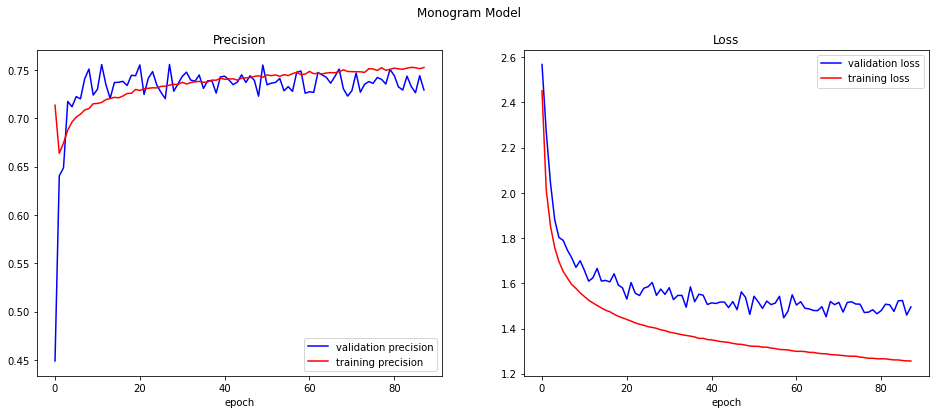

In [28]:
# visualize precision and loss on model training
plt.figure(figsize=(16,6))
plt.suptitle('Monogram Model')
plt.subplot(1,2,1)
plt.title('Precision')
plt.plot(hist1.history['val_precision'], 'b-', label='validation precision')
plt.plot(hist1.history['precision'], 'r-', label='training precision')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(hist1.history['val_loss'], 'b-', label='validation loss')
plt.plot(hist1.history['loss'], 'r-', label='training loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [29]:
print('{:.5f}'.format(hist1.history['precision'][-30]))
print('{:.5f}'.format(hist1.history['val_precision'][-30]))
print('{:.5f}'.format(hist1.history['loss'][-30]))
print('{:.5f}'.format(hist1.history['val_loss'][-30]))

0.74516
0.74892
1.30498
1.47627


In [35]:
# save the model, for sanity purposes
mod1.save('lstm.h5')

In [33]:
hist_df = pd.DataFrame(hist1.history)
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loss           88 non-null     float64
 1   precision      88 non-null     float64
 2   val_loss       88 non-null     float64
 3   val_precision  88 non-null     float64
dtypes: float64(4)
memory usage: 2.9 KB


In [34]:
hist_df.to_csv('history.csv')

## Model Inference
Here we test the models with several latest news in three categories: lifestyle, economy, and religion

In [30]:
infer = [
    "Gut bacteria influence brain development. Researchers discover biomarkers that indicate early brain injury in extreme premature infants. Extremely premature infants are at a high risk for brain damage. Researchers have now found possible targets for the early treatment of such damage outside the brain: Bacteria in the gut of premature infants may play a key role. The research team found that the overgrowth of the gastrointestinal tract with the bacterium Klebsiella is associated with an increased presence of certain immune cells and the development of neurological damage in premature babies. Complex interplay: the gut-immune-brain axis The early development of the gut, the brain and the immune system are closely interrelated. Researchers refer to this as the gut-immune-brain axis. Bacteria in the gut cooperate with the immune system, which in turn monitors gut microbes and develops appropriate responses to them. In addition, the gut is in contact with the brain via the vagus nerve as well as via the immune system. 'We investigated the role this axis plays in the brain development of extreme preterm infants,' says the first author of the study, David Seki. 'The microorganisms of the gut microbiome -- which is a vital collection of hundreds of species of bacteria, fungi, viruses and other microbes -- are in equilibrium in healthy people. However, especially in premature babies, whose immune system and microbiome have not been able to develop fully, shifts are quite likely to occur. These shifts may result in negative effects on the brain,' explains the microbiologist and immunologist.",
    "Job vacancies surge past one million in new record. Job vacancies have hit a record high as the economic recovery continues, according to official figures. The number of vacancies in the three months to August rose above one million for the first time since records began in 2001. Figures also showed employee numbers were back at pre-Covid levels in August, the Office for National Statistics (ONS) said. August payrolls showed another monthly increase of 241,000 to 29.1 million. Business groups said, however, despite the return of staffing levels to pre-pandemic rates there remained high demand for more staff, and there was a risk labour shortages would dampen growth. The ONS deputy statistician, Jonathan Athow, said: 'Early estimates from payroll data suggest that in August the total number of employees is around the same level as before the pandemic, though our surveys show well over a million are still on furlough.' But Mr Athow pointed out that the recovery was not even, with areas such as London and sectors like hospitality and the arts still down. The ONS also cautioned that young people had been badly affected by job losses. 'The overall employment rate continues to recover, particularly among groups such as young workers who were hard hit at the outset of the pandemic, while unemployment has fallen,' he said. Overall, the unemployment rate fell from 4.7% to 4.6% in the three months to July.",
    "Listen to the cry of the Earth': Pope, top Christians urge world leaders to act on climate change. Pope Francis, Archbishop of Canterbury Justin Welby and Orthodox Ecumenical Patriarch Bartholomew released their first joint statement ahead of a U.N. conference. The world's three main Christian leaders issued an unprecedented joint appeal to members of their Churches to 'listen to the cry of the Earth' and back action to stem the effects of climate change. In 'A Joint Message for the Protection of Creation,' Pope Francis, Archbishop of Canterbury Justin Welby and Orthodox Ecumenical Patriarch Bartholomew asked Christians to pray that world leaders at the United Nations Climate Change Conference (COP26) in Glasgow in November make courageous choices. 'We call on everyone, whatever their belief or world view, to endeavor to listen to the cry of the Earth and of people who are poor, examining their behavior and pledging meaningful sacrifices for the sake of the Earth which God has given us,' the message said. Francis heads the 1.3 billion-member Roman Catholic Church, Bartholomew is the spiritual leader of the world's some 220 million Orthodox Christians and Welby is the senior bishop of the worldwide Anglican Communion, which has about 85 million members.",
    "Headteachers call for reform of school admissions to redress attainment gap. ASCL says proportion of places should be ringfenced for disadvantaged pupils outside catchment area. Headteachers have called for an overhaul of school admissions policies to prioritise places for children from disadvantaged backgrounds as a way of addressing the widening attainment gap between richer and poorer pupils. Under proposals put forward by the Association of School and College Leaders (ASCL), a proportion of places in oversubscribed schools in England could be ringfenced for disadvantaged pupils who live outside the catchment area. Within the current system, there is a similar requirement for children in care, but disadvantaged children lose out, according to ASCL, because their families cannot afford to live within the catchment areas of popular, high-performing schools in affluent neighbourhoods. Amid mounting concern about the disproportionate impact of the Covid pandemic on disadvantaged youngsters, ASCL wants the government to consider asking schools to prioritise places for children who are either eligible for the pupil premium additional funding for those on school meals, or those growing up in persistent poverty, in their oversubscription criteria. The proposal is one of a range of measures outlined in the ASCL report Blueprint for a Fairer Education System. The union acknowledged that any mechanism to bring about admissions changes would need to be carefully thought through, but insisted that bold ideas would be needed if the attainment gap was to be closed. Geoff Barton, general secretary of ASCL, said: “Middle-class parents have the buying power to afford homes in areas near popular schools that are rated as good or outstanding. 'There are, of course, many excellent schools in disadvantaged areas too, but the economics of property ownership mean that disadvantaged families don’t have the same access as middle-class parents to certain schools. This is an entrenched injustice which reinforces an unhealthy division between affluent and disadvantaged areas and children. We have to do more to support schools in challenging circumstances, so that there is a school rated as good or outstanding on every doorstep, but we must also see how we might provide parents and children from disadvantaged backgrounds with fairer access to popular schools in more affluent areas.' The president of ASCL, Pepe Di’Iasio, who is the head of Wales High School in South Yorkshire, welcomed the proposal. 'I do think it needs greater thought, greater clarity, but I do also think that we’ve all got admissions policies already in schools, so it’s about tweaking what we’ve already got to make sure that we recognise that poverty is a key factor.' He said: 'I think it’s fair to say that over the last 20 years we’ve seen a succession of governments try different initiatives and different strategies as part of a levelling-up agenda and to a large degree they’ve had little or no impact.' ASCL’s report, which is the culmination of two years of research, also proposes reducing the number of national assessments in primary schools. The union says exams could be modernised, with greater use of technology to personalise assessment, and would like to see a reduction in the number of end-of-course exams that GCSE students have to face."
]

k = []
for j in range(len(infer)):
    infer[j] = infer[j].lower()
    keywords = kwe1.extract_keywords(text=infer[j])
    k.append([x for x,y in keywords])

print('Keywords from text:')
for i in range(len(k)):
    print(i+1, k[i])

kin = tkn.texts_to_sequences(k)
kou = keras.preprocessing.sequence.pad_sequences(kin, maxlen=invec)
kpr = mod1.predict(kou)
for j in range(len(kpr)):
    print(sorted(zip(kpr[j]*100,enc.classes_), reverse=True)[:3])

Keywords from text:
1 ['brain', 'gut', 'premature', 'immune', 'infants', 'development', 'bacteria', 'system', 'researchers', 'early']
2 ['job', 'vacancies', 'million', 'said', 'august', 'record', 'ons', 'one', 'surge', 'past']
3 ['world', 'pope', 'earth', 'cry', 'listen', 'climate', 'change', 'leaders', 'christians', 'joint']
4 ['schools', 'disadvantaged', 'ascl', 'school', 'children', 'areas', 'places', 'admissions', 'attainment', 'gap']
[(80.17418, 'wellness'), (16.981907, 'lifestyle'), (1.7784702, 'science')]
[(21.51821, 'world news'), (19.678133, 'economy'), (13.069577, 'entertainment')]
[(35.6582, 'world news'), (32.649563, 'environment'), (14.386232, 'religion')]
[(23.701004, 'education'), (21.262138, 'other'), (14.625457, 'politics')]
